In [1]:
import tensorflow as tf
from IPython.core import display
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from math import pi
import kdl as tk
from quaternion import *
from scipy.spatial.transform import Rotation as R

plt.style.use("default")
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Setup of some functions and variables


In [2]:
def rotvec2mat(x):
    return R.as_matrix(R.from_rotvec(x))

In [3]:
# Loading the rivet positions in 3D position vectors
targets = np.load("targets.npy")

In [4]:
# Using tensorflow implementation of KDL, get the urdf, chain and dyn parameters
urdf = tk.urdf_from_file('panda_arm_kdl.urdf')
chain = tk.tk_chain_from_urdf(urdf)
dyn = tk.ChainDynParam(chain)


Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link0']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link1']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link2']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link4']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link5']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link6']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link7']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_hand']/collision[1]


In [5]:
# Transformations from world frame(bullet) of the simulation to the robot frame(kdl):
# For Panda on the floor and for this paper, we used the same frame, but the user can change it from here.
base_pos = tf.cast(np.array([0., 0., 0.])[None], tf.float32)
base_rot_vec = np.array([0., 0., 0.])
base_rot_mat = tf.cast(rotvec2mat(base_rot_vec), tf.float32)
base_rot_mat_inv = tf.cast(tf.transpose(base_rot_mat), tf.float32)

def kdl2bullet_x(x):
    """
    param: x: [batch, 3] position in kdl (wrt robot base frame)
    return: [batch, 3] position in bullet (wrt bullet world frame)
    """
    return tf.einsum('ij, aj->ai',base_rot_mat, x) + base_pos

def bullet2kdl_x(x):
    """
    param: x: [batch, 3] position in bullet (wrt bullet world frame)
    return: [batch, 3] position in kdl (wrt robot base frame)
    """
    return tf.einsum('ij, aj->ai',base_rot_mat_inv, x - base_pos)

def kdl2bullet_q(x):
    """
    param: x: [batch, 9] vectorized rotation matrix in kdl (wrt robot base frame)
    return: [batch, 4] quaternion vector in bullet (wrt bullet world frame)
    """
    kdl_end_rot_mat = tf.reshape(x, (x.shape[0], 3,3))
    world_end_rot_mat =  tf.einsum('ij, ajk->aik', base_rot_mat, kdl_end_rot_mat)
    return rot2quat(world_end_rot_mat)

def bullet2kdl_q(x):
    """
    param: x: [batch, 9] vectorized rotation matrix in bullet (wrt bullet world frame)
    return: [batch, 4] quaternion vector in kdl (wrt robot base frame)
    """
    world_end_rot_mat = tf.reshape(x, (x.shape[0], 3,3))
    kdl_end_rot_mat =  tf.einsum('ij, ajk->aik', base_rot_mat_inv, world_end_rot_mat)
    return rot2quat(kdl_end_rot_mat)
        
def kdl2bullet_xq(x):
    """
    param: x: [batch, 12] position + vectorized rotation matrix in kdl (wrt robot base frame)
    return: [batch, 3], [batch, 4]  position, quaternion in bullet (wrt bullet world frame)
    """
    return kdl2bullet_x(x[:, :3]), kdl2bullet_q(x[:, 3:])

def bullet2kdl_xq(x):
    """
    param: x: [batch, 12] position + vectorized rotation matrix in bullet (wrt bullet world frame)
    return: [batch, 3], [batch, 4]  position, quaternion in kdl (wrt robot base frame)
    """
    return bullet2kdl_x(x[:, :3]), bullet2kdl_q(x[:, 3:])


### Defining the end-pose cost

In [6]:
# Quaternion cost
quats_xyz = Quaternion(create_unit_rotations(angle=pi/2))
u = tf.constant([0.        , np.pi/2, 0. ])       
theta = tf.linalg.norm(u)
u = u/theta
mu = tf.cast(utils.axis_angle2quats(u, theta), tf.float32)[None]

mu_  = Quaternion(tf.tile(mu, (3,1)))
rot_mu =  mu_ * quats_xyz
u = Quaternion(rot_mu) - mu_
u = u/tf.linalg.norm(u, axis=-1)[:,None]
norms = tf.constant([1, 1e-5, 1e-5])
cov = tf.reduce_sum(tf.einsum('k,kij->kij', 
                                  norms,
                                  tf.einsum('ki, kj->kij',u,u)), axis=0)
cov += 1e-6 * tf.eye(4)

prec = tf.linalg.inv(cov)
mu_quat = mu[None]
def normalS3_log_prob(x):
    """
    x : [hole_nb, batch_nb, 4]
    Quaternion lognormal distribution
    """
    mu__ = Quaternion(tf.tile(mu_quat, (x.q.shape[0], x.q.shape[1], 1)))
    diff = x - mu__
    quad = -0.5*tf.linalg.einsum('hbi,hbi->hb',diff, tf.linalg.einsum('ij,hbj->hbi',prec,diff))
    return quad


# Position cost
cov_x = tf.linalg.diag([1e-3, 1e-3, 1e-3])
prec_x = tf.linalg.inv(cov_x)

def normal_log_prob_(mu_x):
    """
    mu_x : [hole_nb, 1, 3]
    """
    def normal_log_prob(x):
        """
        x: [hole_nb, batch_nb, 3]
        Cartesian lognormal distribution
        """
        diff = x - mu_x
        quad = -0.5*tf.linalg.einsum('hbi,hbi->hb',diff, tf.linalg.einsum('ij,hbj->hbi',prec_x,diff))
        return quad
    return normal_log_prob

def normal_log_prob__(mu_x):
    """
    mu_x : [1, 3]
    """
    def normal_log_prob(x):
        """
        x: [batch_nb, 3]
        Cartesian lognormal distribution
        """
        diff = x - mu_x
        quad = -0.5*tf.linalg.einsum('bi,bi->b',diff, tf.linalg.einsum('ij,bj->bi',prec_x,diff))
        return quad
    return normal_log_prob

### Joint limit costs

In [7]:
joint_limits = tf.stack(chain.joint_limits)
lower_limits = joint_limits[:,0][None, None]
upper_limits = joint_limits[:,1][None, None]
def plot_limits(q):
    plt.plot(joint_limits, "o")
    plt.plot(q, "kx")
    
mean_limits = tf.reduce_mean(joint_limits,-1)[None]
@tf.function
def cost_joint_limit(q):
    rl = tf.math.minimum(q-lower_limits, 0)
    ru = tf.math.maximum(q-upper_limits, 0)
    return 0.5*(tf.linalg.einsum('hbi,hbi->hb',rl, rl) + tf.linalg.einsum('hbi,hbi->hb',ru, ru))


### Optimization to find the joint configuration corresponding to rivet hole positions within joint limits

In [38]:
batch = 100
mu_x = tf.cast(targets, tf.float32)[:, None]
normal_log_prob = normal_log_prob_(mu_x)
hole_nb = targets.shape[0]
@tf.function
def cost_ik(q):
    """
    q: [hole_nb, batch_nb, nb_dof]
    """
    batch = q.shape[1]
    q_vec = tf.reshape(q, (hole_nb*batch, q.shape[2]))
    xs_ = chain.xs(q_vec, layout=tk.FkLayout.xm)[:, -1]
    
    # if robot base frame is changed, uncomment this
    # world_end_pos, world_end_quats = kdl2bullet_xq(xs_)
    
    world_end_pos = tf.reshape(xs_[..., :3], (hole_nb, batch, 3))
    world_end_quats = rot2quat(tf.reshape(xs_[...,3:], (hole_nb*batch, 3, 3)))
    world_end_quats = tf.reshape(world_end_quats, (hole_nb, batch, 4))
        
    ee_pos_cost = -normal_log_prob(world_end_pos)
    ee_quat_cost = -normalS3_log_prob(Quaternion(world_end_quats))
    return ee_pos_cost +  ee_quat_cost*0.1 + cost_joint_limit(q)*1e3


In [39]:
# Start is the initial guess on the joint configurations within the joint limits
start  = tf.Variable(
    tf.random.uniform(shape=(hole_nb, batch, 7),
                      minval=tf.stack(chain.joint_limits)[:,0],
                      maxval=tf.stack(chain.joint_limits)[:,1]))

In [40]:
@tf.function
def cost():
    return cost_ik(start)
optimizer = tf.keras.optimizers.Adam(0.5)

In [41]:
# Stochastic Gradient Descent
for i in range(1000000):
    try :
        optimizer.minimize(cost,[start] )
        display.clear_output(wait=True)
        tf.print(cost())
    except KeyboardInterrupt:
        break

[[0.0136928353 0.00205218676 28.6053429 ... 1.2855624 1.88164067 150.84433]
 [0.117895037 2.51295924 0.0333358757 ... 0.00888453238 141.427505 2.78022337]
 [283.60556 0.0678079873 2.20021011e-05 ... 0.00283085555 164.586914 0.00391187798]
 ...
 [0.743559778 105.851601 105.372284 ... 4.89236546 7.65790319e-05 0.142225549]
 [0.00155566598 8.79184532 6.15583467 ... 42.2957306 25.0212383 1.20989334e-05]
 [3.05878925 3.02442765 1.95380771 ... 0.00956265535 3.0229342 3.59414816]]


### Filtering to get converging solutions

In [42]:
# first version of the found joint configurations,
# some may not be within the joint limits nor correspond to rivet positions since the SGD did not converge
good_q__ = start
good_q__.shape

TensorShape([84, 100, 7])

In [43]:
# Second version containing all the solutions in the joint configuraitons
good_q_ = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    good_q_[i] = good_q__[i][cost_joint_limit(good_q__)[i] < 1e-2]
    max_nb = min(max_nb,good_q_[i].shape[0])
    
for i in range(hole_nb):
    good_q_[i] = good_q_[i][:max_nb]
    
good_q_ = tf.stack(good_q_)
good_q_.shape

TensorShape([84, 81, 7])

In [44]:
# This cell and the next cell can be used to see if the chosen configuration is within the joint limits-
i = 0 # rivet hole
j = 0 # configuration nb

[[2.40561349e-10]]


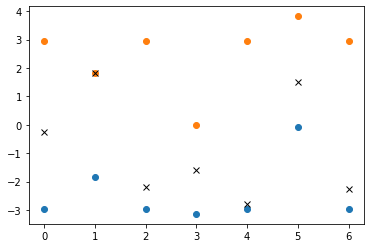

In [45]:
plot_limits(good_q_[i][j])
tf.print(cost_joint_limit(good_q_[i][j][None]))
j+=1
# i+=1

In [46]:
# A function to check if the configurations correspond to rivet positions within the tolerance
def check_q(q):
    batch = q.shape[1]
    q_vec = tf.reshape(q, (hole_nb*batch, q.shape[2]))
    xs_ = chain.xs(q_vec, layout=tk.FkLayout.xm)[:, -1]
    
    world_end_pos = tf.reshape(xs_[..., :3], (hole_nb, batch , 3))
    world_end_quats = rot2quat(tf.reshape(xs_[...,3:], (hole_nb*batch, 3, 3)))
    world_end_quats = tf.reshape(world_end_quats, (hole_nb, batch, 4))
    
    good_xs = [None for i in range(hole_nb)]
    good_xs_ind = [None for i in range(hole_nb)]
    max_nb = 1e5
    for i in range(hole_nb):
#         print(world_end_pos[i][normal_log_prob(world_end_pos)[i] > -1e-2].shape)
        good_xs[i] = world_end_pos[i][normal_log_prob(world_end_pos)[i] > -1e-1]
        good_xs_ind[i] = np.where(normal_log_prob(world_end_pos)[i] > -1e-1)
        max_nb = min(max_nb,good_xs[i].shape[0])

    for i in range(hole_nb):
        good_xs[i] = good_xs[i][:max_nb]

    good_xs = tf.stack(good_xs)
    return world_end_pos, good_xs, good_xs_ind
    

In [47]:
xs, good_xs, good_xs_ind = check_q(good_q_)
# xs : all the end positions corresponding to good_q_
# good_xs : all the end positions within the good tolerance corresponding to good_q_
good_xs.shape

TensorShape([84, 32, 3])

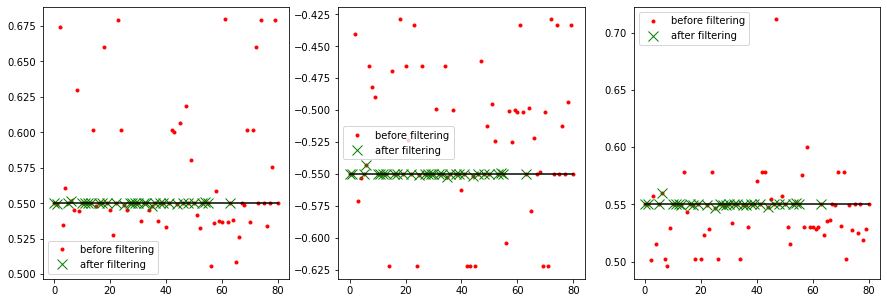

In [52]:
# Plotting good_xs
fig,ax = plt.subplots(ncols=3, figsize=(15,5))
N = xs.shape[1]
j = 0 # choose a rivet hole
for i in range(3):
    ax[i].plot(range(N), xs[j, :,i], "r.", label="before filtering")
    ax[i].plot(good_xs_ind[j][0][:good_xs.shape[1]], good_xs[j,:,i], "gx", ms=10, label="after filtering")
    ax[i].plot(range(N), [mu_x[j,:,i]]*N, "k")
    ax[i].legend()
# plt.legend()

In [53]:
# third version of the joint configurations, within joint limits and within the tolerance of corresponding rivet position
good_q = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    good_q[i] = good_q_[i][-normal_log_prob(xs)[i] < 1e-1]
    max_nb = min(max_nb,good_q[i].shape[0])
    
for i in range(hole_nb):
    good_q[i] = good_q[i][:max_nb]
    
good_q = tf.stack(good_q)
good_q.shape

TensorShape([84, 32, 7])

In [54]:
i = 0
j = 1

[[0]]


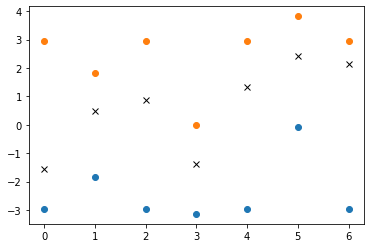

In [55]:
plot_limits(good_q[j,i])
tf.print(cost_joint_limit(good_q[j,i][None]))
i+=1

In [62]:
# check if there is any nan
if tf.where(tf.math.is_nan(good_q) == True).shape[0] == 0:
    print("no nan")
else:
    print("check nans")

no nan


### Displacement cost

In [ ]:
# Force: 
F = 150 # in Newton
nF = tf.constant([-1, 0., 0]) #direction of force in world frame coordinates

In [64]:
# For 7dof robot
K = tf.eye(chain.nb_joint)*1e5
C = tf.linalg.diag(tf.ones(7)*0.06)

# chosen frequency
w = tf.constant(150.)

def compute_H(w, M, J, C, K):
    """
    Finds the displacement force frequency response function H(w)
    """
    real = -(w**2)*M+K
    imag = w*C
    comp = tf.complex(real, imag)
#     inv = tf.linalg.inv(comp, adjoint=True)
    try:
        inv = tf.linalg.inv(comp, adjoint=True)
    except:
        r0  = tf.linalg.pinv(real) @ imag
        y11 = tf.linalg.pinv(imag @ r0 + real)
        y10 = -r0 @ y11

        inv = tf.cast(tf.complex(y11,y10), dtype =comp.dtype)
    return J@inv@tf.transpose(J, (0,2,1))

def displacement(q):
        q_vec = tf.reshape(q, (q.shape[0]*q.shape[1], q.shape[2]))
        M = dyn.inertia_matrix(q_vec)
        J = chain.jacobian(q_vec, layout=tk.FkLayout.x)
        J = tf.complex(J, tf.zeros_like(J))
        H = compute_H(w, M, J, C, K)
        
        A = tf.transpose(H, perm=(0,2,1),conjugate=True)@H
        evals, evecs = tf.linalg.eigh(A)

        evals = tf.reshape(evals, (q.shape[0], q.shape[1], 3))
        return tf.math.sqrt(tf.math.abs(tf.math.real(evals)))

@tf.function
def displacement_(w, q):
        q_vec = tf.reshape(q, (q.shape[0]*q.shape[1], q.shape[2]))
        M = dyn.inertia_matrix(q_vec)
        J = chain.jacobian(q_vec, layout=tk.FkLayout.x)
        J = tf.complex(J, tf.zeros_like(J))
        H = compute_H(w, M, J, C, K)
        A = tf.transpose(H, (0,2,1),conjugate=True)@H
        evals, evecs = tf.linalg.eigh(A)
        evals = tf.reshape(evals, (q.shape[0], q.shape[1], 3))
        return  tf.math.sqrt(tf.math.abs(tf.math.real(evals)))

In [ ]:
good_q.shape

In [ ]:
data_nb = 50
config_nb = 500
w__ = 66*2*pi
w__ = 450
w_ = tf.cast(np.linspace(0, w__, data_nb), tf.float32)
disp = np.zeros((hole_nb, config_nb, data_nb))
disp_x = np.zeros((hole_nb, config_nb, data_nb, 3))
disp_x
q_random = tf.random.uniform(shape=(hole_nb, config_nb,7), minval=tf.stack(chain.joint_limits)[:,0],maxval=tf.stack(chain.joint_limits)[:,1])
for i in range(data_nb):
#     d_ = displacement_(w_[i], good_q[:,:config_nb])
    d_ = displacement_(w_[i], q_random[:,:config_nb])
#     disp[:,:, i] = tf.reduce_max(displacement_(w_[i], q_random), -1)
#     disp[:,:, i] = tf.reduce_max(d_, -1)
    disp_x[:,:,i] = d_


In [ ]:
# disp = tf.einsum('abci,i->abc',disp_x, tf.constant([1., 0., 0.]))
disp = tf.reduce_max(disp_x, -1)

In [ ]:
fig,ax = plt.subplots(1, figsize=(4,3))
for j in range(1):
    for i in range(config_nb):
        ax.plot(w_,disp[j,i]*1e3, "-", label="Point A")
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xlabel('$\omega$'+' (rad/s)')
ax.set_ylabel('$\eta$'+' (mm/N)')
ax.grid("on")
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, w_[-1], 50)
minor_ticks = np.arange(0, w_[-1], 10)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

def forward(x):
    return x * 130.


def inverse(x):
    return x/130.

secax = ax.secondary_yaxis('right', functions=(forward, inverse))
secax.set_ylabel('$\Delta x$'+' (mm)')
secax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
# ax.set_facecolor("w")
# plt.legend()

### Optimization for displacement

In [ ]:
batch = 500
q_test = tf.Variable(good_q[:, :batch], trainable=True)
@tf.function
def cost_(): 
    return cost_ik(q_test)

In [ ]:
@tf.function
def train_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(q_test)
        disp_cost = tf.norm(displacement(q_test),ord=2,axis=-1 )
        loss = cost_ik(q_test) + 1e1*disp_cost
        
    grads = tape.gradient(loss, [q_test])

#     J = chain.jacobian(q_test, layout=tk.FkLayout.xq)
#     Jv = J[:, :3]
#     Jv_pinv = tf.linalg.pinv(Jv)
    
#     Jw = J[:,3:]
#     Jw_ = tf.concat([tf.zeros((batch, 1, chain.nb_joint)), Jw],1)
#     Jq = 0.5*utils.omega_quat_left(kdl_q)@Jw_
#     Jq_pinv = tf.linalg.pinv(Jq)
    
#     dquat = world_q - mu_batch
#     dx = world_end_pos - mu_x
#     grads_ = grads[0] + 10*tf.linalg.matvec(Jq_pinv, dquat) + 100*tf.linalg.matvec(Jv_pinv, dx)
#     grads_ = tf.clip_by_value(grads[0], -1e15, 1e15)
    grads_ = grads[0]
    grads_ = tf.where(tf.math.is_nan(grads_), tf.zeros_like(grads_), grads_)
    optimizer.apply_gradients(zip([grads_], [q_test]))
    return loss, grads

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.05)

In [ ]:
for i in range(1000000):
    try :
        loss, grads = train_step()
        display.clear_output(wait=True)
        tf.print(loss)
    except KeyboardInterrupt:
        break

In [ ]:
# check if there is any nan
tf.where(tf.math.is_nan(loss) == True)

In [ ]:
xs_,_,_ = check_q(q_test)
print(xs_.shape)
i=0

In [ ]:
j = 0

In [ ]:
plt.plot(tf.linalg.norm(displacement(good_q[j,:batch][None])[0],axis=-1), "bx", label="Before optimization")
plt.plot(tf.linalg.norm(displacement(q_test[j][None])[0],axis=-1), "rx", label="After optimization")
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
j+=1
# do with 3 different w values

In [ ]:
(displacement(good_q[:,:batch])*1e3).numpy()[...,0].flatten().shape

In [ ]:
fig,ax=plt.subplots(1,figsize=(4,3))
density = 1
after_opt_data = displacement(q_test)*1e3
before_opt_data = displacement(good_q[:,:batch])*1e3
# ax.hist(tf.linalg.norm(after_opt_data,axis=-1).numpy().flatten(), density=density, color="b", label="After optimization")
# ax.hist(tf.linalg.norm(before_opt_data,axis=-1).numpy().flatten(), density=density, alpha=0.3, color="r", label="Before optimization")
# ax.plot(after_opt_data.numpy().flatten(), np.ones_like(after_opt_data.numpy().flatten())*(-0.1), "bx", alpha=0.1)
# ax.plot(before_opt_data.numpy().flatten(), np.ones_like(after_opt_data.numpy().flatten())*(-0.2), "rx", alpha=0.1)

ax.hist(after_opt_data.numpy()[...,0].flatten(),density=density,color="b", label="After optimization")
ax.hist(before_opt_data.numpy()[...,0].flatten(), color="r",density=density, alpha=0.3, label="Before optimization")
ax.plot(after_opt_data.numpy()[...,0].flatten(), np.ones_like(after_opt_data.numpy()[...,0].flatten())*(-100), "bx", alpha=0.1)
ax.plot(before_opt_data.numpy()[...,0].flatten(), np.ones_like(after_opt_data.numpy()[...,0].flatten())*(-300), "rx", alpha=0.1)



ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_xlabel('$\eta$'+' (mm/N)')
ax.set_ylabel("density")
secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('$\Delta x$'+' (mm)')
secax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.legend(loc=7)

ax.set_yticks([])

In [ ]:
fig,ax = plt.subplots(ncols=3)
j = 0
for i in range(3):
    ax[i].plot(before_opt_data.numpy()[j,:,i])

In [ ]:
fig,ax = plt.subplots(figsize=(4,3))
density = 1
after_opt_data = displacement(q_test)*1e3
before_opt_data = displacement(good_q[:,:batch])*1e3

ax.boxplot([ before_opt_data.numpy()[...,0].flatten(), after_opt_data.numpy()[...,0].flatten()])

# ax.boxplot([tf.linalg.norm(before_opt_data,axis=-1).numpy().flatten(), 
#             tf.linalg.norm(after_opt_data,axis=-1).numpy().flatten()])

# ax.boxplot(tf.linalg.norm(after_opt_data,axis=-1).numpy().flatten())
ticks = ["Before", "After"]
ax.set_xticks([1,2])
ax.set_xticklabels( ticks, rotation=0 )
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylabel('$\eta$'+' (mm/N)')

secax = ax.secondary_yaxis('right', functions=(forward, inverse))
secax.set_ylabel('$\Delta x$'+' (mm)')
secax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [ ]:
print(np.std(after_opt_data.numpy()[...,0].flatten()))
np.mean(after_opt_data.numpy()[...,0].flatten())

In [ ]:
print(np.std(before_opt_data.numpy()[...,0].flatten()))
np.mean(before_opt_data.numpy()[...,0].flatten())